<a href="https://colab.research.google.com/github/rwxhuang/lstm_vs_transformers/blob/main/Architecture_dataset_sizes_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from typing import Tuple, Union, Optional, List

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/6S898_data/"
df = pd.read_csv(DATA_PATH + "PJME_hourly.csv")
df = df.set_index('Datetime')
df.head()

Mounted at /content/drive


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
df.index = pd.to_datetime(df.index)

# Prepare Datasets

In [ ]:
def get_dataset(percent_of_database):
  date_cutoff = df.index[int(percent_of_database * len(df))]
  train = df.loc[df.index < date_cutoff]
  date_cutoff_10_percent = df.index[int(0.9 * len(df))]
  test = df.loc[(df.index >= date_cutoff_10_percent)]

  def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

  sc_train = MinMaxScaler()
  training_data = sc_train.fit_transform(train)

  seq_length = 10
  x, y = sliding_windows(training_data, seq_length)
  X_train, Y_train = torch.Tensor(np.array(x)), torch.Tensor(np.array(y))
  # X_train, Y_train = Variable(torch.Tensor(np.array(x))), Variable(torch.Tensor(np.array(y)))

  sc_test = MinMaxScaler()
  test_data = sc_test.fit_transform(test)
  x, y = sliding_windows(test_data, seq_length)
  X_test, Y_test = torch.Tensor(np.array(x)), torch.Tensor(np.array(y))
  # X_test, Y_test = Variable(torch.Tensor(np.array(x))), Variable(torch.Tensor(np.array(y)))

  return X_train, Y_train, X_test, Y_test, sc_train, sc_test

# LSTM Model

## Define the LSTM Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length=10):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)

        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [ ]:
def train_model(X_train, Y_train, percent, num_epochs=500, learning_rate=0.1):
  input_size = 1
  hidden_size = 2
  num_layers = 1

  num_classes = 1

  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

  criterion = torch.nn.MSELoss()    # mean-squared error for regression
  optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
  # optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      lstm.zero_grad()
      outputs = lstm(X_train)

      # obtain the loss function
      loss = criterion(outputs, Y_train)

      loss.backward()

      optimizer.step()
      if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

  now = datetime.now()
  torch.save(lstm.state_dict(), os.path.join(DATA_PATH, 'model-weights/lstm_' + str(percent) + '_weights'))

## Training

In [ ]:
percents = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
for percent in percents:
  X_train, Y_train, X_test, Y_test, _, _ = get_dataset(percent)
  train_model(X_train, Y_train, percent)

Epoch: 0, loss: 0.79284
Epoch: 100, loss: 0.00347
Epoch: 200, loss: 0.00147
Epoch: 300, loss: 0.00098
Epoch: 400, loss: 0.00095
Epoch: 0, loss: 0.55705
Epoch: 100, loss: 0.00224
Epoch: 200, loss: 0.00147
Epoch: 300, loss: 0.00119
Epoch: 400, loss: 0.00104
Epoch: 0, loss: 0.09277
Epoch: 100, loss: 0.00107
Epoch: 200, loss: 0.00090
Epoch: 300, loss: 0.00071
Epoch: 400, loss: 0.00076
Epoch: 0, loss: 0.66233
Epoch: 100, loss: 0.00837
Epoch: 200, loss: 0.00122
Epoch: 300, loss: 0.00109
Epoch: 400, loss: 0.00100
Epoch: 0, loss: 0.13109
Epoch: 100, loss: 0.00158
Epoch: 200, loss: 0.00068
Epoch: 300, loss: 0.00065
Epoch: 400, loss: 0.00064
Epoch: 0, loss: 0.23708
Epoch: 100, loss: 0.00138
Epoch: 200, loss: 0.00070
Epoch: 300, loss: 0.00065
Epoch: 400, loss: 0.00063
Epoch: 0, loss: 0.30709
Epoch: 100, loss: 0.00103
Epoch: 200, loss: 0.00067
Epoch: 300, loss: 0.00058
Epoch: 400, loss: 0.00055
Epoch: 0, loss: 0.02019
Epoch: 100, loss: 0.00142
Epoch: 200, loss: 0.00068
Epoch: 300, loss: 0.00067
Ep

# Evaluation

In [ ]:
#Load model from drive
input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1
losses = []

for percent in percents:
  X_train, Y_train, X_test, Y_test, sc_train, sc_test = get_dataset(percent)
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
  state_dict = torch.load(DATA_PATH + 'model-weights/lstm_' + str(percent) + '_weights')
  lstm.load_state_dict(state_dict)
  lstm.eval()
  with torch.no_grad():
    losses.append(torch.nn.MSELoss()(lstm(X_test), Y_test).item())
  # print(train_predict[:10], Y_train[:10])

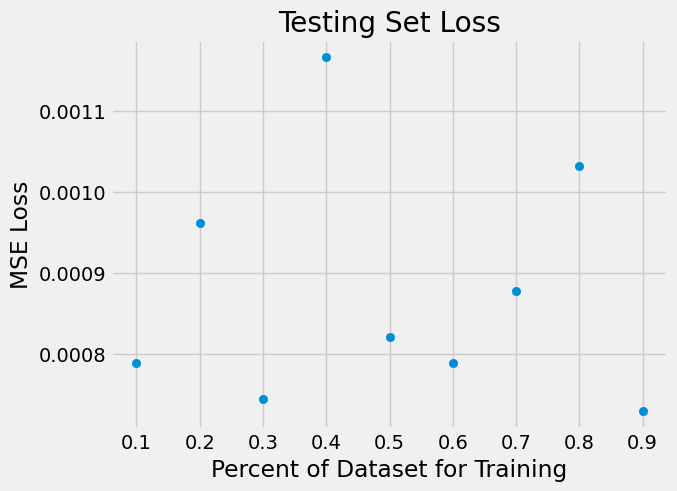

In [ ]:
plt.xlabel('Percent of Dataset for Training')
plt.ylabel('MSE Loss')
plt.title('Testing Set Loss')
plt.scatter(percents, losses)

# Transformer Model

# Define Transformer Model

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

for percent in percents:
  X_train, Y_train, X_test, Y_test, _, _ = get_dataset(percent)
  model = build_model(
      input_shape,
      head_size=256,
      num_heads=4,
      ff_dim=4,
      num_transformer_blocks=4,
      mlp_units=[128],
      mlp_dropout=0.4,
      dropout=0.25,
  )

  model.compile(
      loss="mean_squared_error",
      optimizer=keras.optimizers.Adam(learning_rate=1e-4)
  )
  #model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=10, \
      restore_best_weights=True)]

  model.fit(
      X_train.numpy(),
      Y_train.numpy(),
      validation_split=0.2,
      epochs=10,
      batch_size=64,
      callbacks=callbacks,
  )

  model.save(os.path.join(DATA_PATH, 'model-weights/transformer_' + str(percent) + '_weights'), save_format="h5")

Epoch 1/10
147/147 [==============================] - 36s 180ms/step - loss: 0.0379 - val_loss: 0.0101
Epoch 2/10
147/147 [==============================] - 33s 226ms/step - loss: 0.0195 - val_loss: 0.0063
Epoch 3/10
147/147 [==============================] - 24s 166ms/step - loss: 0.0139 - val_loss: 0.0043
Epoch 4/10
147/147 [==============================] - 27s 182ms/step - loss: 0.0106 - val_loss: 0.0036
Epoch 5/10
147/147 [==============================] - 31s 209ms/step - loss: 0.0093 - val_loss: 0.0031
Epoch 6/10
147/147 [==============================] - 25s 172ms/step - loss: 0.0083 - val_loss: 0.0030
Epoch 7/10
147/147 [==============================] - 27s 184ms/step - loss: 0.0077 - val_loss: 0.0027
Epoch 8/10
147/147 [==============================] - 25s 168ms/step - loss: 0.0068 - val_loss: 0.0025
Epoch 9/10
147/147 [==============================] - 27s 184ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 10/10
147/147 [==============================] - 25s 171ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
404/404 [==============================] - 84s 183ms/step - loss: 0.0333 - val_loss: 0.0096
Epoch 2/10
404/404 [==============================] - 73s 182ms/step - loss: 0.0110 - val_loss: 0.0044
Epoch 3/10
404/404 [==============================] - 69s 172ms/step - loss: 0.0074 - val_loss: 0.0028
Epoch 4/10
404/404 [==============================] - 75s 185ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 5/10
404/404 [==============================] - 76s 187ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 6/10
404/404 [==============================] - 74s 183ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 7/10
404/404 [==============================] - 76s 188ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 8/10
404/404 [==============================] - 72s 179ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 9/10
404/404 [==============================] - 73s 181ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 10/10
404/404 [==============================] - 71s 175ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
441/441 [==============================] - 88s 182ms/step - loss: 0.0388 - val_loss: 0.0080
Epoch 2/10
441/441 [==============================] - 81s 183ms/step - loss: 0.0105 - val_loss: 0.0031
Epoch 3/10
441/441 [==============================] - 85s 192ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 4/10
441/441 [==============================] - 83s 188ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 5/10
441/441 [==============================] - 82s 186ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 6/10
441/441 [==============================] - 88s 199ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 7/10
441/441 [==============================] - 83s 189ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 8/10
441/441 [==============================] - 85s 192ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 9/10
441/441 [==============================] - 83s 188ms/step - loss: 0.0026 - val_loss: 9.2458e-04
Epoch 10/10
441/441 [==============================] - 84s 192ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
697/697 [==============================] - 131s 179ms/step - loss: 0.0165 - val_loss: 0.0024
Epoch 2/10
697/697 [==============================] - 137s 196ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 3/10
697/697 [==============================] - 119s 171ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 4/10
697/697 [==============================] - 118s 169ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 5/10
697/697 [==============================] - 121s 174ms/step - loss: 0.0024 - val_loss: 9.4756e-04
Epoch 6/10
697/697 [==============================] - 130s 186ms/step - loss: 0.0021 - val_loss: 7.7965e-04
Epoch 7/10
697/697 [==============================] - 123s 177ms/step - loss: 0.0018 - val_loss: 7.1860e-04
Epoch 8/10
697/697 [==============================] - 123s 176ms/step - loss: 0.0016 - val_loss: 6.6599e-04
Epoch 9/10
697/697 [==============================] - 128s 184ms/step - loss: 0.0014 - val_loss: 6.3355e-04
Epoch 10/10
697/697 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
954/954 [==============================] - 186s 185ms/step - loss: 0.0216 - val_loss: 0.0030
Epoch 2/10
954/954 [==============================] - 172s 181ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 3/10
954/954 [==============================] - 184s 193ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 4/10
954/954 [==============================] - 168s 176ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 5/10
954/954 [==============================] - 172s 180ms/step - loss: 0.0024 - val_loss: 9.3434e-04
Epoch 6/10
954/954 [==============================] - 176s 184ms/step - loss: 0.0020 - val_loss: 7.6276e-04
Epoch 7/10
954/954 [==============================] - 170s 178ms/step - loss: 0.0017 - val_loss: 7.1111e-04
Epoch 8/10
954/954 [==============================] - 175s 184ms/step - loss: 0.0015 - val_loss: 6.8874e-04
Epoch 9/10
954/954 [==============================] - 171s 179ms/step - loss: 0.0013 - val_loss: 6.5733e-04
Epoch 10/10
954/954 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
991/991 [==============================] - 191s 183ms/step - loss: 0.0098 - val_loss: 0.0017
Epoch 2/10
991/991 [==============================] - 178s 180ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 3/10
991/991 [==============================] - 175s 177ms/step - loss: 0.0027 - val_loss: 9.1966e-04
Epoch 4/10
991/991 [==============================] - 185s 187ms/step - loss: 0.0022 - val_loss: 8.1269e-04
Epoch 5/10
991/991 [==============================] - 185s 187ms/step - loss: 0.0018 - val_loss: 7.3542e-04
Epoch 6/10
991/991 [==============================] - 190s 192ms/step - loss: 0.0016 - val_loss: 6.8953e-04
Epoch 7/10
991/991 [==============================] - 188s 190ms/step - loss: 0.0014 - val_loss: 6.3907e-04
Epoch 8/10
991/991 [==============================] - 179s 180ms/step - loss: 0.0012 - val_loss: 6.0058e-04
Epoch 9/10
991/991 [==============================] - 172s 173ms/step - loss: 0.0011 - val_loss: 5.8112e-04
Epoch 10/10
991/991 [===============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
1248/1248 [==============================] - 235s 181ms/step - loss: 0.0152 - val_loss: 0.0015
Epoch 2/10
1248/1248 [==============================] - 226s 181ms/step - loss: 0.0041 - val_loss: 8.5020e-04
Epoch 3/10
1248/1248 [==============================] - 220s 176ms/step - loss: 0.0028 - val_loss: 6.9441e-04
Epoch 4/10
1248/1248 [==============================] - 216s 173ms/step - loss: 0.0022 - val_loss: 5.6861e-04
Epoch 5/10
1248/1248 [==============================] - 223s 179ms/step - loss: 0.0018 - val_loss: 5.0779e-04
Epoch 6/10
1248/1248 [==============================] - 225s 180ms/step - loss: 0.0014 - val_loss: 4.6428e-04
Epoch 7/10
1248/1248 [==============================] - 222s 178ms/step - loss: 0.0012 - val_loss: 4.5496e-04
Epoch 8/10
1248/1248 [==============================] - 216s 173ms/step - loss: 0.0010 - val_loss: 4.1981e-04
Epoch 9/10
1248/1248 [==============================] - 215s 173ms/step - loss: 9.3237e-04 - val_loss: 4.1260e-04
Epoch 10/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
1504/1504 [==============================] - 272s 174ms/step - loss: 0.0213 - val_loss: 0.0026
Epoch 2/10
1504/1504 [==============================] - 263s 175ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 3/10
1504/1504 [==============================] - 285s 189ms/step - loss: 0.0036 - val_loss: 9.9262e-04
Epoch 4/10
1504/1504 [==============================] - 282s 188ms/step - loss: 0.0026 - val_loss: 7.4421e-04
Epoch 5/10
1504/1504 [==============================] - 276s 183ms/step - loss: 0.0019 - val_loss: 5.9210e-04
Epoch 6/10
1504/1504 [==============================] - 258s 171ms/step - loss: 0.0014 - val_loss: 5.3318e-04
Epoch 7/10
1504/1504 [==============================] - 277s 184ms/step - loss: 0.0011 - val_loss: 4.9357e-04
Epoch 8/10
1504/1504 [==============================] - 259s 172ms/step - loss: 9.8481e-04 - val_loss: 4.7828e-04
Epoch 9/10
1504/1504 [==============================] - 257s 171ms/step - loss: 8.7318e-04 - val_loss: 4.5426e-04
Epoch 10/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
1542/1542 [==============================] - 277s 173ms/step - loss: 0.0194 - val_loss: 0.0016
Epoch 2/10
1542/1542 [==============================] - 283s 184ms/step - loss: 0.0040 - val_loss: 8.7914e-04
Epoch 3/10
1542/1542 [==============================] - 261s 169ms/step - loss: 0.0026 - val_loss: 6.4834e-04
Epoch 4/10
1542/1542 [==============================] - 265s 172ms/step - loss: 0.0019 - val_loss: 5.7922e-04
Epoch 5/10
1542/1542 [==============================] - 287s 186ms/step - loss: 0.0015 - val_loss: 5.3156e-04
Epoch 6/10
1542/1542 [==============================] - 310s 201ms/step - loss: 0.0012 - val_loss: 4.8562e-04
Epoch 7/10
1542/1542 [==============================] - 315s 205ms/step - loss: 0.0010 - val_loss: 4.5654e-04
Epoch 8/10
1542/1542 [==============================] - 316s 205ms/step - loss: 8.8792e-04 - val_loss: 4.5039e-04
Epoch 9/10
1542/1542 [==============================] - 314s 204ms/step - loss: 8.1115e-04 - val_loss: 4.4261e-04
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation

In [ ]:
import tensorflow as tf
res = []
for percent in percents:
  X_train, Y_train, X_test, Y_test, sc_train, sc_test = get_dataset(percent)
  model = tf.keras.models.load_model(DATA_PATH + 'model-weights/transformer_' + str(percent) + '_weights')
  res.append(model.evaluate(X_test.numpy(), Y_test.numpy()))
res

689/689 [==============================] - 30s 43ms/step - loss: 7.3270e-04


[0.0017093558562919497,
 0.0011175972176715732,
 0.0008059569518081844,
 0.0007052834844216704,
 0.0007508777780458331,
 0.0006801722920499742,
 0.0007901829667389393,
 0.0007256466196849942,
 0.0007326986524276435]

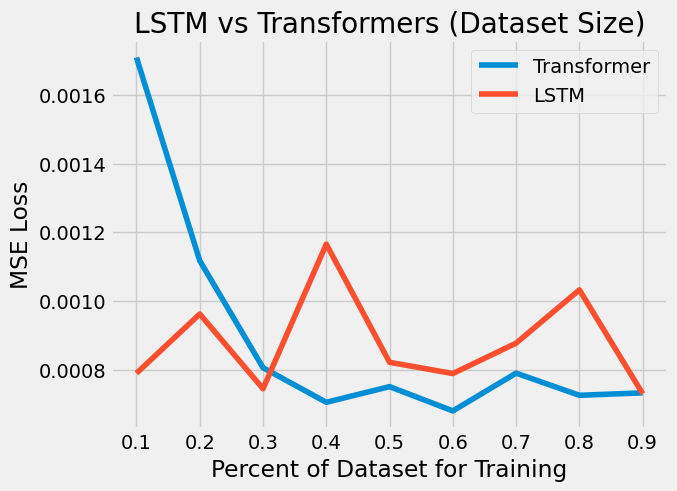

In [ ]:
res = [0.0017093558562919497,
 0.0011175972176715732,
 0.0008059569518081844,
 0.0007052834844216704,
 0.0007508777780458331,
 0.0006801722920499742,
 0.0007901829667389393,
 0.0007256466196849942,
 0.0007326986524276435]

plt.xlabel('Percent of Dataset for Training')
plt.ylabel('MSE Loss')
plt.title('LSTM vs Transformers (Dataset Size)')
plt.plot(percents, res, label='Transformer')
plt.plot(percents, losses, label='LSTM')
plt.legend()
plt.show()